In [1]:
import torch
from torch.autograd import Variable as V


w_true = torch.Tensor([1, 2, 3])
X = torch.cat([torch.ones(100, 1), torch.randn(100, 2)], 1)
y = torch.mv(X, w_true) + torch.randn(100)
X = V(X)
y = V(y)
w = V(torch.randn(3), requires_grad=True)
gamma = 0.1

In [2]:
losses = []
for epoc in range(100):
    w.grad = None
    y_pred = torch.mv(X, w)
    loss = torch.mean((y - y_pred) ** 2)
    loss.backward()
    w.data = w.data - gamma * w.grad.data
    losses.append(loss.data[0])

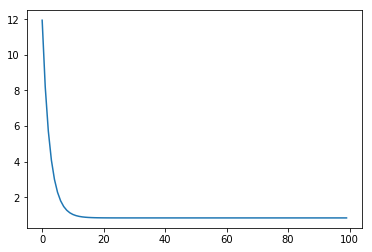

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt


plt.plot(losses)

In [4]:
w

Variable containing:
 0.9940
 1.9866
 3.0755
[torch.FloatTensor of size 3]

In [5]:
from torch import nn, optim


net = nn.Linear(in_features=3, out_features=1, bias=False)
optimizer = optim.SGD(net.parameters(), lr=0.1)
loss_fn = nn.MSELoss()

In [6]:
losses = []
for epoc in range(100):
    optimizer.zero_grad()
    y_pred = net(X)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.data[0])

In [7]:
list(net.parameters())

[Parameter containing:
  0.9940  1.9866  3.0755
 [torch.FloatTensor of size 1x3]]

In [8]:
from sklearn.datasets import load_iris


iris = load_iris()
X = iris.data[:100]
y = iris.target[:100]
X = V(torch.Tensor(X))
y = V(torch.Tensor(y))

In [9]:
net = nn.Linear(4, 1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.25)

In [10]:
losses = []
for epoc in range(1000):
    optimizer.zero_grad()
    y_pred = net(X)
    loss = loss_fn(y_pred, y.view(100, 1))
    loss.backward()
    optimizer.step()
    losses.append(loss.data[0])

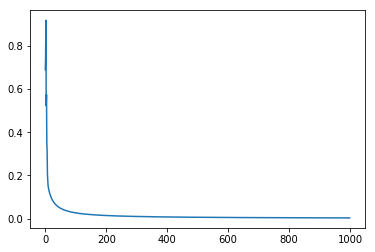

In [11]:
plt.plot(losses)

In [12]:
h = net(X)
prob = nn.functional.sigmoid(h)
y_pred = prob > 0.5
(y.byte().view(100, 1) == y_pred).sum()

Variable containing:
 100
[torch.ByteTensor of size 1]

In [13]:
from sklearn.datasets import load_digits


digits = load_digits()
X = digits.data
y = digits.target
X = V(torch.Tensor(X))
y = V(torch.LongTensor(y))
net = nn.Linear(X.size()[1], 10)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [14]:
losses = []
for epoc in range(1000):
    optimizer.zero_grad()
    y_pred = net(X)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.data[0])

In [15]:
_, y_pred = torch.max(net(X), 1)
(y_pred == y).float().sum() / len(y)

Variable containing:
 0.9905
[torch.FloatTensor of size 1]